In [1]:
%matplotlib inline
import sys, os

import numpy as np
import pandas as pd
import cv2, PIL
import matplotlib.pyplot as plt
import time

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.cuda.is_available()

True

# Making my own dataset
[This is an example](https://medium.com/mlearning-ai/building-custom-datasets-for-pytorch-deep-learning-image-classification-29989971652d)

In [2]:
train_folder = r'../data/rawData/train'
test_folder = r'../data/rawData/test'
pred_folder = r'../data/rawData/pred'

In [3]:
len( os.listdir(pred_folder))

3054

# Annotation Preparation

In [4]:
def build_csv(directory_string, output_csv_name):
    """Builds a csv file for pytorch training from a directory of folders of images.
    Install csv module if not already installed.
    Args: 
    directory_string: string of directory path, e.g. r'.\data\train'
    output_csv_name: string of output csv file name, e.g. 'train.csv'
    Returns:
    csv file with file names, file paths, class names and class indices
    """
    import csv
    directory = directory_string
    class_lst = os.listdir(directory) #returns a LIST containing the names of the entries(folder names in this case) in the directory.
    class_lst.sort() #IMPORTANT 
    with open(output_csv_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['file_name', 'file_path', 'class_name', 'class_index']) #create column names
        for class_name in class_lst:
            class_path = os.path.join(directory, class_name) #concatenates various path components with exactly one directory separator (‘/’) except the last path component. 
            file_list = os.listdir(class_path) #get list of files in class folder
            for file_name in file_list:
                file_path = os.path.join(directory, class_name, file_name) #concatenate class folder dir, class name and file name
                writer.writerow([file_name, file_path, class_name, class_lst.index(class_name)-1]) #write the file path and class name to the csv file
    return

In [5]:
build_csv(train_folder, 'train.csv')
build_csv(test_folder, 'test.csv')

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
len(train_df)

10134

In [7]:
test_df.sample(10)

,file_name,file_path,class_name,class_index
2957,23779.jpg,data/rawData/test/street/23779.jpg,street,5
719,22626.jpg,data/rawData/test/forest/22626.jpg,forest,1
1477,22804.jpg,data/rawData/test/mountain/22804.jpg,mountain,3
2070,24132.jpg,data/rawData/test/sea/24132.jpg,sea,4
2608,21355.jpg,data/rawData/test/street/21355.jpg,street,5
1670,22222.jpg,data/rawData/test/mountain/22222.jpg,mountain,3
2781,20266.jpg,data/rawData/test/street/20266.jpg,street,5
1204,21799.jpg,data/rawData/test/glacier/21799.jpg,glacier,2
1173,23443.jpg,data/rawData/test/glacier/23443.jpg,glacier,2
1283,20860.jpg,data/rawData/test/glacier/20860.jpg,glacier,2


In [8]:
class_zip = zip(train_df['class_index'], train_df['class_name'])
my_list = []
for index, name in class_zip:
    tup = tuple((index, name))
    my_list.append(tup)
unique_list = list(set(my_list))
print('Training:')
print(sorted(unique_list))
print()

class_zip = zip(test_df['class_index'], test_df['class_name'])
my_list = []
for index, name in class_zip:
  tup = tuple((index, name))
  my_list.append(tup)
unique_list = list(set(my_list))
print('Testing:')
print(sorted(unique_list))

Training:
[(0, 'buildings'), (1, 'forest'), (2, 'glacier'), (3, 'mountain'), (4, 'sea'), (5, 'street')]

Testing:
[(0, 'buildings'), (1, 'forest'), (2, 'glacier'), (3, 'mountain'), (4, 'sea'), (5, 'street')]


In [9]:
class_names = list(train_df['class_name'].unique())
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Creating Customized Training And Testing Datasets

In [16]:
class Dataset(torch.utils.data.Dataset): # inheritin from Dataset class
    def __init__(self, csv_file, root_dir="", transform=None):
        self.annotation_df = pd.read_csv(csv_file)
        self.root_dir = root_dir # root directory of images, leave "" if using the image path column in the __getitem__ method
        self.transform = transform

    def __len__(self):
        return len(self.annotation_df) # return length (numer of rows) of the dataframe

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.annotation_df.iloc[idx, 1]) #use image path column (index = 1) in csv file
        image = cv2.imread(image_path) # read image by cv2
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert from BGR to RGB for matplotlib
        class_name = self.annotation_df.iloc[idx, 2] # use class name column (index = 2) in csv file
        class_index = self.annotation_df.iloc[idx, 3] # use class index column (index = 3) in csv file
        if self.transform:
            image = self.transform(image)
        return image, class_name, class_index

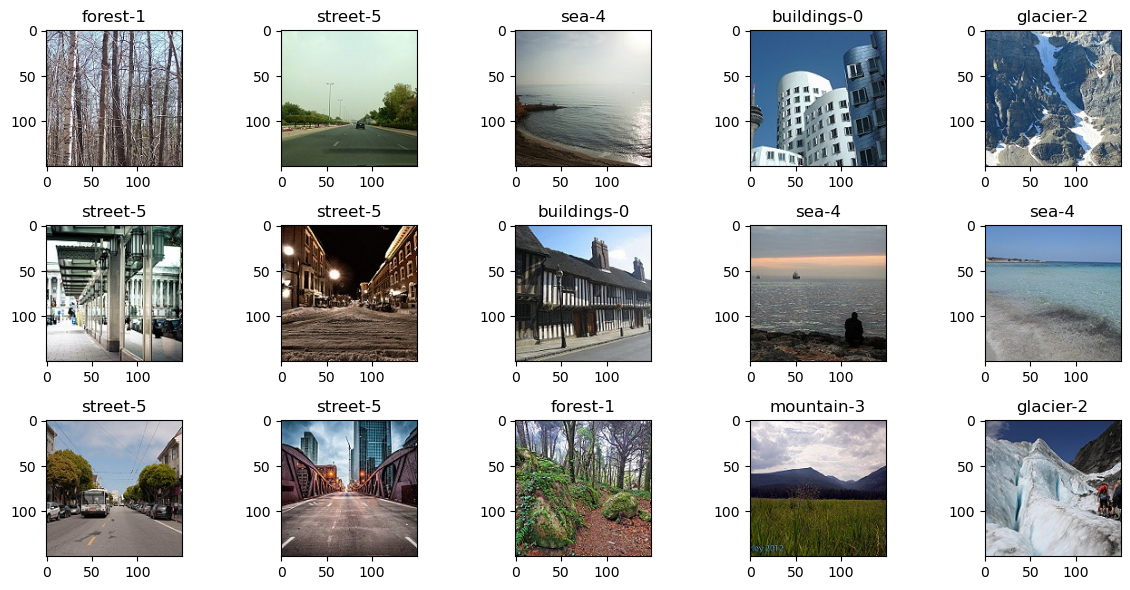

In [24]:
#test dataset class without transformation:
train_dataset_untransformed = Dataset(csv_file='train.csv', root_dir="", transform=None)

#visualize 10 random images from the loaded dataset
plt.figure(figsize=(12,6))
for i in range(15):
    idx = np.random.randint(0, len(train_dataset_untransformed))
    image, class_name, class_index = train_dataset_untransformed[idx]
    ax=plt.subplot(3,5,i+1) # create an axis
    ax.title.set_text(class_name + '-' + str(class_index)) # create a name of the axis based on the img name
    plt.imshow(image) # show the img
plt.tight_layout()

# Image Transformation

A common practice for image classification tasks is transforming input images. Transforming is the act of converting the image from one form to another, in terms of size, shape, pixel ranges etc., while keeping essential image information largely unchanged. Ideally, this is aimed at increasing the robustness of the classifier as it is exposed to many variations of the same image class, and not only ‘nice looking’ ones.

___An important step is to convert the image array information to tensors. This is the data format that PyTorch uses, instead of numpy or PIL arrays. The final tensor arrays will be of the form Channel * Height * Width (C * H * W), instead of the original (H * W * C). Hence, if we want to visualize an image, `permute` is used to restore the order.___

***Another important transformation step we will use is [Normalization](https://inside-machinelearning.com/en/why-and-how-to-normalize-data-object-detection-on-image-in-pytorch-part-1/). As you know, a channel of a normal 24-bit color image has the intensity range from 0 to 255 (8-bit), with potentially very different distributions across different images. By normalizing them (usually to a range around 0 to 1), training would encounter less frequent non-zero gradients, leading to faster learning. More information on Normalization and other common transformation techniques can be found in the links below.***

In PyTorch, common image transformation methods are available in the torchvision.transforms module. Multiple transforming steps such as resizing, augmenting and normalizing can be chained together using Compose.

# Create a transform pipeline

In [79]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Resize((224, 224), interpolation=PIL.Image.Resampling.BILINEAR)
])

# Create datasets with transforms: 

In [80]:
train_dataset = Dataset(csv_file='train.csv', root_dir="", transform=image_transform)
test_dataset = Dataset(csv_file='test.csv', root_dir="", transform=image_transform)

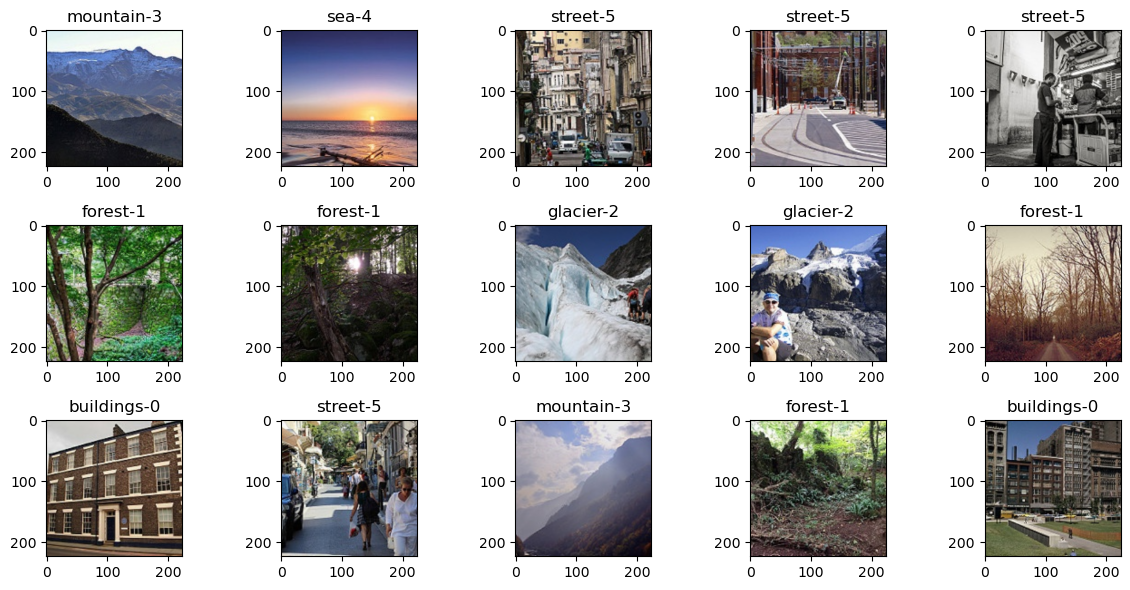

In [82]:
#visualize 10 random images from the loaded transformed train_dataset
plt.figure(figsize=(12, 6))
for i in range(0,15):
    idx = np.random.randint(0, len(train_dataset))
    image, class_name, class_index = train_dataset[idx]
    ax=plt.subplot(3,5,i+1) # create an axis
    ax.title.set_text(class_name + '-' + str(class_index)) # create a name of the axis based on the img name
    # The final tensor arrays will be of the form (C * H * W), instead of the original (H * W * C), 
    # hence use permute to change the order
    plt.imshow((0.5+0.5*image).permute(1, 2, 0)) # show the img
plt.tight_layout()

In [39]:
im1 = np.array([[1,2],[3,4]])/4)

SyntaxError: unmatched ')' (2962129972.py, line 1)

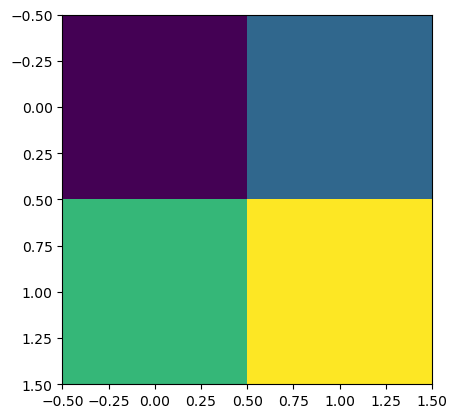

In [36]:
plt.imshow(im1)

In [37]:
cv2

<module 'cv2' from '/opt/anaconda3/envs/studhub/lib/python3.8/site-packages/cv2/__init__.py'>